In [19]:
import json
import os

import uuid

import matplotlib.pyplot as plt


In [20]:
data_dir = "generated"

def load_case(case_name):
    case_dir = os.path.join(data_dir, case_name)
    results = {}
    for data_filename in os.listdir(case_dir):
        with open(os.path.join(case_dir, data_filename), 'r') as data_file:
            results[os.path.splitext(data_filename)[0]] = json.load(data_file)
    return results

cases = {}
for case in os.listdir(data_dir):
    cases[case] = load_case(case)

In [21]:
def tr(text):
    translation_map = {
        "YABIL": "Własne",
        "YABIL_parallel": "Własne [wielowątkowo]",
        "Addition": "Dodawanie",
        "Division": "Dzielenie",
        "Multiplication": "Mnożenie",
        "Subtraction": "Odejmowanie",
    }
    if text in translation_map:
        return translation_map[text]
    return text

In [22]:
def load(data):
    plot_data = {}
    for entry in data:
        name = entry["name"]
        operation, library, n_aggregate = name.split("/")
        n, aggregate = n_aggregate.split("_")
        if aggregate == "mean":
            cpu_time = entry["cpu_time"]
            if operation not in plot_data:
                plot_data[operation] = {}
            if library not in plot_data[operation]:
                plot_data[operation][library] = {}
            plot_data[operation][library][int(n)] = cpu_time
    return plot_data

def plot_common(operation_name, operation_data, exclude=[]):
    for lib_name, lib_data in operation_data.items():
        if lib_name in exclude:
            continue
        x, y = lib_data.keys(), lib_data.values()
        plt.plot(x, y, "--", marker=".", markersize=5)

    plt.legend([" ".join(tr(label).split("_")) for label in operation_data.keys() if label not in exclude])
    plt.title(tr(operation_name))
    plt.xlabel("Rozmiar danych [bity]")
    plt.ylabel("Czas operacji [ns]")
    plt.grid()
    plt.xlim(0, 1e6)
    plt.ylim(0)
    plt.gca().ticklabel_format(style="plain")
    plt.savefig(f"{operation_name}_{uuid.uuid4().hex}.png", bbox_inches="tight", dpi=300)
    plt.show()

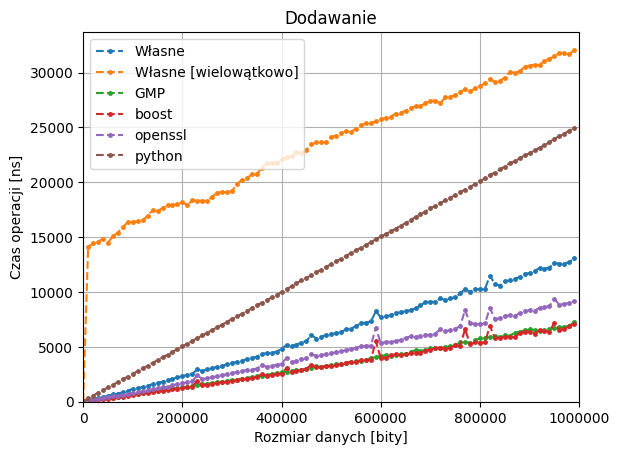

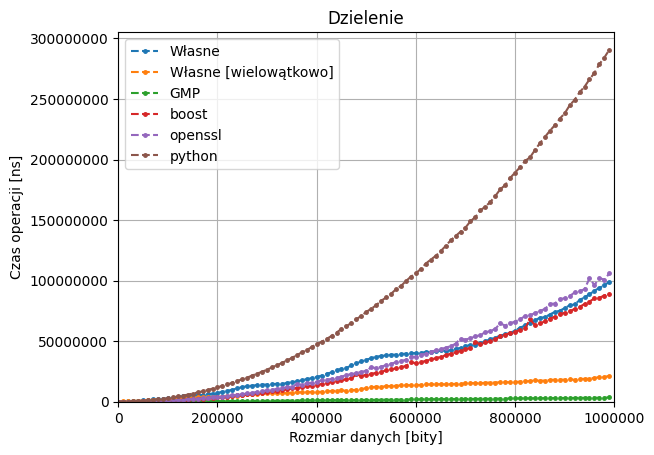

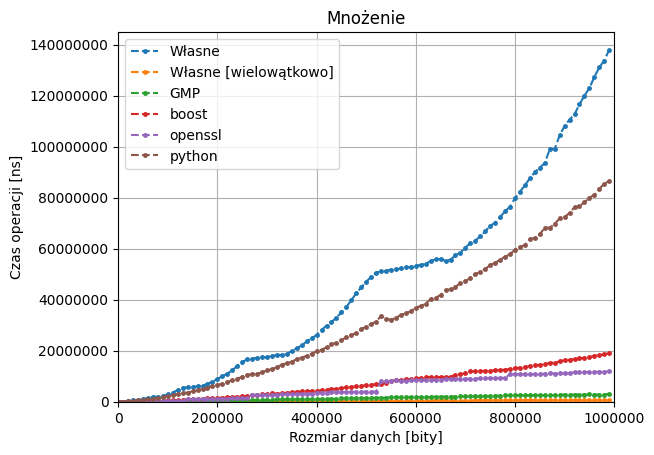

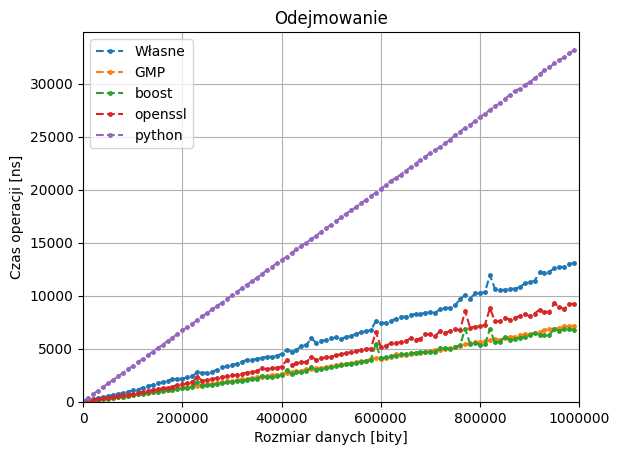

In [23]:
# Optimized libraries comparison

all_data = cases["normal"]["results_all"]["benchmarks"]
data = load(all_data)

for operation, operation_data in data.items():
    plot_common(operation, operation_data, ["BIGINT_mattmccutchen"])



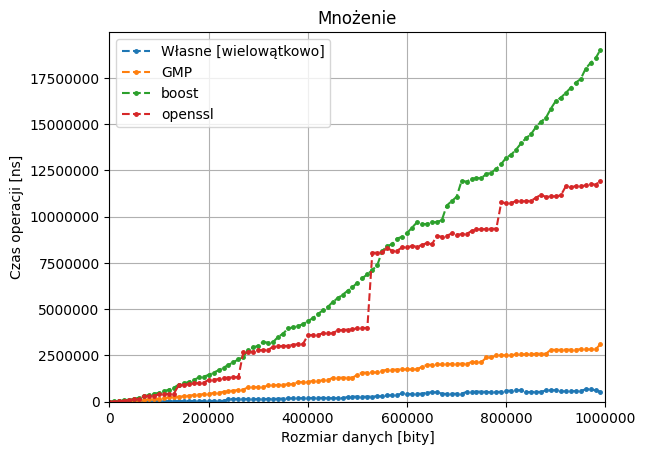

In [24]:
# Optimized libraries comparison (only multiplication)

all_data = cases["normal"]["results_all"]["benchmarks"]
data = load(all_data)
plot_common("Multiplication", data["Multiplication"], ["BIGINT_mattmccutchen", "python", "YABIL"])


# -----------------------------------------

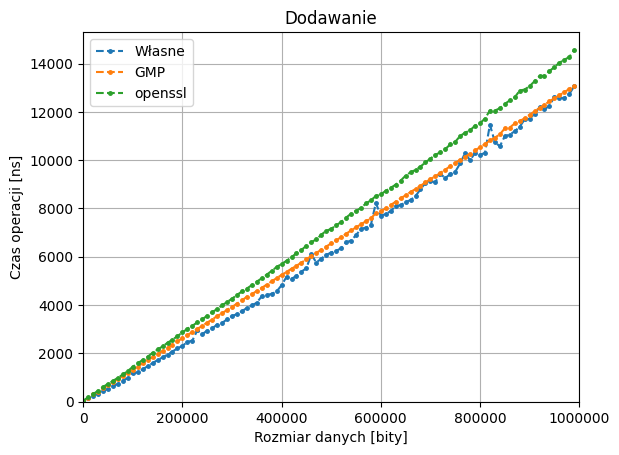

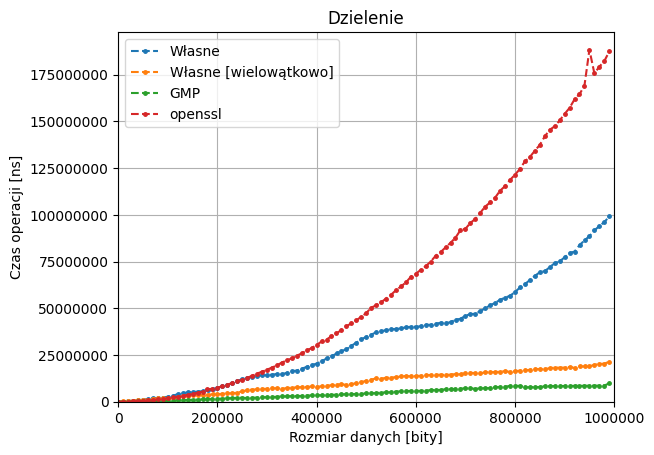

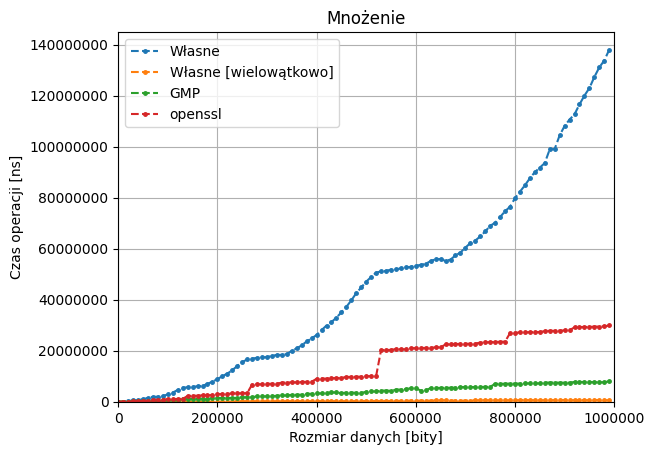

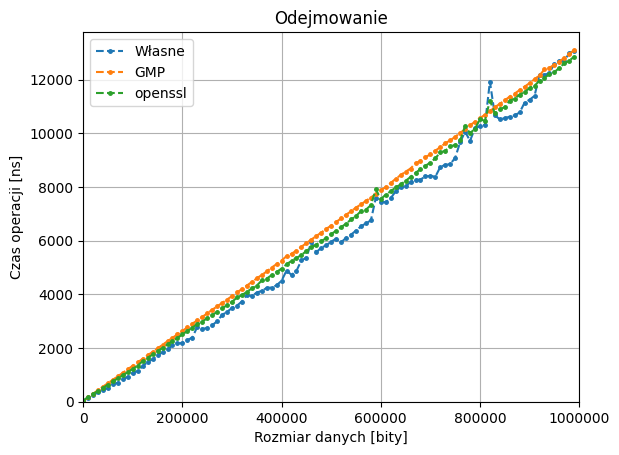

In [29]:
# C++ only libraries comparison

gmp_data = load(cases["no_optimizations"]["results_GMP"]["benchmarks"])
openssl_data = load(cases["no_optimizations"]["results_openssl"]["benchmarks"])
all_data = load(cases["normal"]["results_all"]["benchmarks"])

normal = {}
for op, data in all_data.items():
    if op not in normal:
        normal[op] = {}
    normal[op]["YABIL"] = data["YABIL"]
    if op != "Addition" and "YABIL_parallel" in data:
        normal[op]["YABIL_parallel"] = data["YABIL_parallel"]

for k in gmp_data:
    normal[k].update(gmp_data[k])
    normal[k].update(openssl_data[k])

data = normal

for operation, operation_data in data.items():
    plot_common(operation, operation_data)

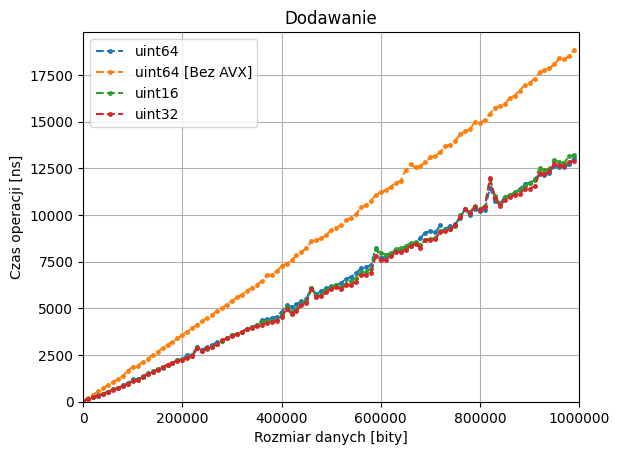

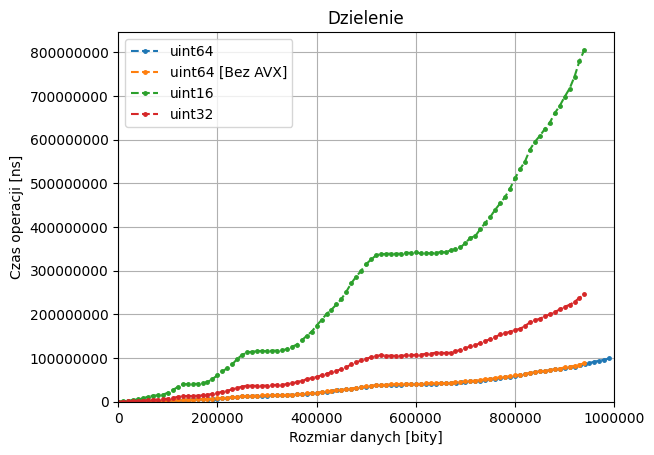

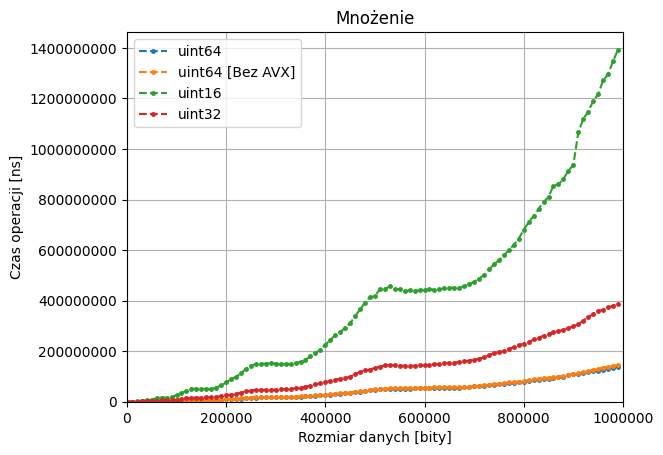

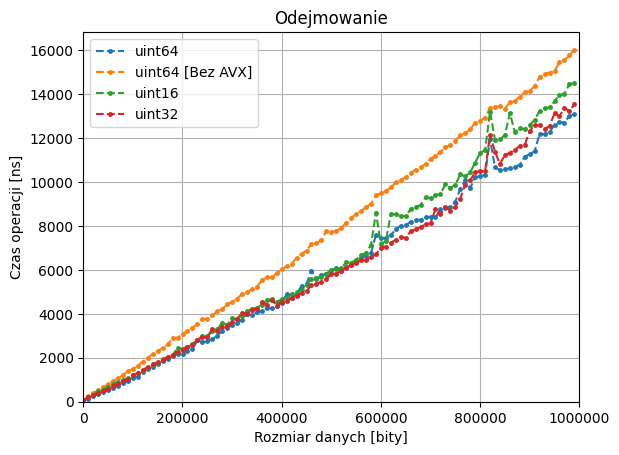

In [36]:
# All YABIL options

def rearrange(data, new="YABIL", old="YABIL"):
    res = {}
    for op, lib_data in data.items():
        if op not in res:
            res[op] = {}
        res[op][new] = lib_data[old]
        # if op != "Addition" and "YABIL_parallel" in lib_data:
        #     res[op][f"{new}_parallel"] = lib_data["YABIL_parallel"]
    return res

all_data = rearrange(load(cases["normal"]["results_all"]["benchmarks"]), "uint64")
no_avx = rearrange(load(cases["no_optimizations"]["results_YABIL"]["benchmarks"]), "uint64 [Bez AVX]")
# tbb = rearrange(load(cases["normal_tbb"]["results_YABIL"]["benchmarks"]), "uint64 [TBB]")
uint16 = rearrange(load(cases["uint16"]["results_YABIL"]["benchmarks"]), "uint16")
uint32 = rearrange(load(cases["uint32"]["results_YABIL"]["benchmarks"]), "uint32")

for k in all_data:
    all_data[k].update(no_avx[k])
    # all_data[k].update(tbb[k])
    all_data[k].update(uint16[k])
    all_data[k].update(uint32[k])

for operation, operation_data in all_data.items():
    plot_common(operation, operation_data)